# 1. Quantum SWAP Test
A way to find the magnitude of $\langle \psi \vert \phi \rangle$ for two single-qubit states $\psi$ and $\phi$. We outline two methods of achieving this - one using an Ancilla qubit, one without it. Both methods rely upon measuring an ensemble of identical $|0\psi\phi\rangle$ states passed through the same quantum circuit and recording the probabilities of different outcomes. In Qiskit, the simulator does this for us.

In [22]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram
sim = Aer.get_backend('aer_simulator')

from numpy import sqrt

### Method 1: using an Ancilla Qubit.
Idea: We use the circuit below and measure the probability of obtaining the ancilla qubit in state $|0\rangle$.

Proof of working: The initial state of the system is $|0\psi\phi\rangle$. We can compute the state of the system after all the operations to be
$$|\Psi\rangle = |0\rangle \otimes \left(\frac{|\psi\phi\rangle + |\phi\psi\rangle}{2}\right) + |1\rangle \otimes \left(\frac{|\psi\phi\rangle - |\phi\psi\rangle}{2}\right)$$ 
Now say $\frac{|\psi\phi\rangle + |\phi\psi\rangle}{2} = \alpha |00\rangle + \beta |01\rangle + \gamma |10\rangle + \delta |11\rangle$. So the probability of observing $0$ when measuring the ancilla qubit is $\mathbb{P}(0) = \sum_{x, y \in {0, 1}} \mathbb{P} (|0xy\rangle) = |\alpha|^2 + |\beta|^2 + |\gamma|^2 + |\delta|^2$. We can now find $\alpha, \beta, \gamma, \delta$ by computing $\frac{|\psi\phi\rangle + |\phi\psi\rangle}{2}$ from $|\psi\rangle = a|0\rangle + b|1\rangle$ and $|\phi\rangle = c|0\rangle + d|1\rangle$. Skipping the calculation, we finally get $$\mathbb{P}(0) = \frac{1}{2} + \frac{|\bar{a}c + \bar{b}d|^2}{2} = \frac{1}{2} + \frac{|\langle\psi|\phi\rangle|^2}{2}$$ from which the magnitude of $\langle\psi|\phi\rangle$ is immediate.

In [23]:
# For this implementation we require the Fredkin or Controlled Swap or CSWAP gate.
# We implement it below, but it can be implemented using the cswap or fredkin methods of class QuantumCircuit as well.
def fredkin_gate():
    c = QuantumCircuit(3)
    c.cx(1, 2); c.ccx(0, 2, 1); c.cx(1, 2)
    return c

def swap_test_1(psi: list, phi: list, shots: int=4096):
    ckt = QuantumCircuit(3, 1)
    ckt.initialize(psi, 1); ckt.initialize(phi, 2)
    ckt.barrier()
    ckt.h(0)
    ckt = ckt.compose(fredkin_gate())
    #ckt.append(fredkin_gate(), range(3)) # 0 is control, 1&2 are target for the fredkin gate.
    ckt.h(0)
    ckt.measure(0, 0)
    counts = sim.run(transpile(ckt, sim), shots=shots).result().get_counts()
    prob_0 = counts["0"]/shots
    return ckt, sqrt(2*prob_0 - 1)

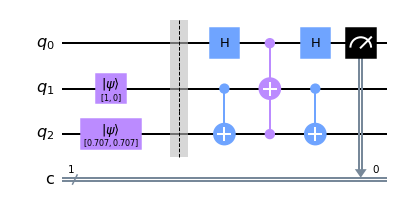

In [24]:
ckt, ans = swap_test_1([1, 0], [1/sqrt(2), 1/sqrt(2)], 2048)
ckt.draw(output="mpl")

In [25]:
# Note that this is only approximate since shots is finite
print(ans)

0.7146622891268295


# Method 2: Without Ancilla qubit.
Idea: We write the state $|\psi\phi\rangle$ in the Bell basis, then change from the Bell basis to the computational basis and then measure the probability of obtaining the state $|11\rangle$.

Proof of working: Let $|\psi\rangle = a|0\rangle + b|1\rangle$ and $|\phi\rangle = c|0\rangle + d|1\rangle$. 

Then we have 
$$
\begin{align}
|\psi\phi\rangle &= ac|00\rangle + ad|01\rangle + bc|10\rangle + bd|11\rangle \\
&= \frac{1}{\sqrt{2}}\bigg[ (ac + bd)|\beta_{00}\rangle + (ad + bc)|\beta_{01}\rangle + (ac - bd)|\beta_{10}\rangle + (ad - bc)|\beta_{11}\rangle \bigg]
\end{align}
$$
and hence
$$ \begin{align} 
\mathbb{P}(|\beta_{11}\rangle) + \frac{|\langle\psi|\phi\rangle|^2}{2} &= \frac{|ad-bc|^2 + |\bar{a}c + \bar{b}d|^2}{2} \\ &= \frac{(|a|^2 + |b|^2)(|c|^2 + |d|^2) - 2\mathcal{R}(\overline{ad}bc) + 2\mathcal{R}(\bar{a}c\overline{\bar{b}d})}{2} \\ &= \frac{1}{2}
\end{align} $$
from which we can obtain $|\langle\psi|\phi\rangle|$. The probability $\mathbb{P}(|\beta_{11}\rangle)$ is calculated by applying the $|\beta_{xy}\rangle \rightarrow |xy\rangle$ change of basis operator to the system and then measuring the probability of getting the basis state $|11\rangle$.

In [26]:
def bell_to_comp():
    c = QuantumCircuit(2)
    c.cx(0, 1); c.h(0)
    return c

def swap_test_2(psi: list, phi: list, shots=4096):
    ckt = QuantumCircuit(2)
    ckt.initialize(psi, 0); ckt.initialize(phi, 1); ckt.barrier()
    ckt = ckt.compose(bell_to_comp())
    ckt.measure_all()
    counts = sim.run(transpile(ckt, sim), shots=shots).result().get_counts()
    ans = sqrt(1 - 2*(counts["11"]/shots))
    return ckt, ans

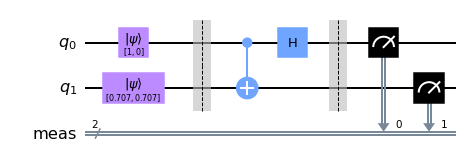

In [27]:
ckt, ans = swap_test_2([1, 0], [1/sqrt(2), 1/sqrt(2)], 2048)
ckt.draw(output="mpl")

In [28]:
print(ans)

0.7036456405748563
